In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import numpy as np
import sys
sys.path.append("../../../")
%load_ext autoreload
%autoreload 2

In [3]:
california_ozone = pd.read_csv("../dataset/cal_o3.csv", index_col = None)

In [4]:
cadf = california_ozone
cadf = cadf[cadf['Time Local'] <= '18:00']
cadf = cadf[cadf['Time Local'] >= '10:00']

In [5]:
county_codes = cadf['County Code'].values
site_code = cadf['Site Num'].values
site_id = [str(county_codes[i]) + str(site_code[i]) for i in range(len(county_codes))]

In [6]:
cadf['ID'] = site_id

In [7]:
cadf.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Date Local',
       'Time Local', 'Date GMT', 'Time GMT', 'Sample Measurement',
       'Units of Measure', 'MDL', 'Uncertainty', 'Qualifier', 'Method Type',
       'Method Code', 'Method Name', 'State Name', 'County Name',
       'Date of Last Change', 'ID'],
      dtype='object')

In [8]:
mask = cadf.groupby(['ID', 'Date Local'])['Sample Measurement'].count() >= 8

In [9]:
cadf = cadf.groupby(['ID', 'Date Local']).mean()[mask]

In [10]:
cadf.reset_index(inplace=True)

In [11]:
cadf = cadf[['ID', 'Date Local', 'Latitude', 'Longitude', 'Sample Measurement']]

In [12]:
m1 = cadf['Date Local'] >= '1990-05-01'
m2 = cadf['Date Local'] <= '1990-09-30'
mf = m1 & m2
cadf = cadf[mf]

In [13]:
m4 = cadf.groupby('ID').count()>=115

In [14]:
cadf = cadf.groupby('ID').mean()[m4]

In [15]:
cadf.dropna(inplace = True)

In [16]:
ca_df = cadf.copy()

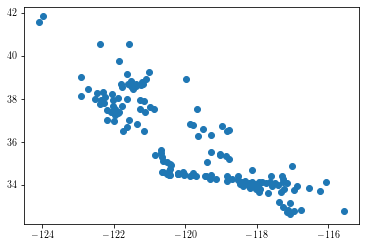

In [17]:
plt.scatter(cadf['Longitude'], cadf['Latitude'])

In [18]:
cadf = cadf[cadf['Latitude']<=34.81]

In [19]:
import geopandas as gpd

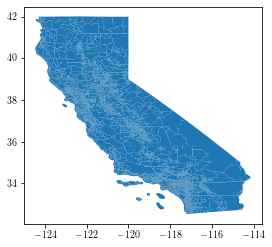

In [20]:
gdf = gpd.read_file("../block_groups/california/tl_2016_06_bg.shp")
gdf['INTPTLAT'] = np.float64(gdf['INTPTLAT'].values)
gdf['INTPTLON'] = np.float64(gdf['INTPTLON'].values)
gdf.plot()

In [21]:
shapes = gdf['geometry'].unique()
centroids = [shapes[i].centroid.wkt for i in range(len(shapes))]
centroids = [centroids[i].split(' ')[1:] for i in range(len(centroids))]
centroids = [[np.float64(centroids[i][0][1:]), np.float64(centroids[i][1][:-1])] for i in range(len(centroids))]
centroids = np.array(centroids)

In [22]:
centroids = centroids[centroids[:, 1] <= 34.81]

In [23]:
cadf

,Latitude,Longitude,Sample Measurement
ID,,,
1111003,34.446661,-119.271224,0.064055
1112002,34.276316,-118.683685,0.071589
1112003,34.280401,-119.314557,0.037592
1113001,34.252390,-119.143182,0.047568
1114,34.398608,-118.824817,0.063365
...,...,...,...
832004,34.637820,-120.457500,0.032198
833001,34.605819,-120.075069,0.041464
834003,34.595900,-120.631315,0.035255


## Let us interpolate over California

In [24]:
X = cadf[['Longitude', 'Latitude']].values
y = cadf[['Sample Measurement']].values * 1000

### Kriging Interpolation

In [25]:
from polire.interpolate import Kriging
## PyKrige takes Longitude Values in the Range 0 to 360 => Add 360 to our values!
X_krig = X.copy()
X_test_krig = centroids.copy()
# X_krig[:, 0] = X_krig[:, 0] + 360
krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
krig.fit(X_krig, y)

X_test_krig[:, 0] = X_test_krig[:, 0] + 360
krig_predictions = krig.predict(X_test_krig)

### Spatial Average

In [26]:
from polire.interpolate import SpatialAverage
spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y)
spatial_predictions = spatial.predict(centroids)

### IDW

For IDW, the authors choose a 250 km radius. Let us likewise choose our training points and use the IDW Class repeatedly.


In [27]:
from polire.interpolate import Idw
from polire.utils.distance import haversine, euclidean
idw = Idw(coordinate_type='Geographic', exponent=1)
idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(data_point, X)
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    idw.fit(X_train, y_train)
    idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))

### $k$-NN, with $k = 1$.

In [28]:
from polire.custom import CustomInterpolator
from sklearn.neighbors import KNeighborsRegressor
knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
knn.fit(X, y)
knn_predictions = knn.predict(centroids)

In [29]:
krig_predictions = np.array(krig_predictions).reshape(-1,)

In [30]:
spatial_predictions = np.array(spatial_predictions).reshape(-1,)

In [31]:
idw_predictions = np.array(idw_predictions).reshape(-1,)

In [32]:
knn_predictions = np.array(knn_predictions).reshape(-1,)

## Correlation Coefficients

In [33]:
from scipy.stats import pearsonr

* Kriging, IDW
* Kriging, KNN
* Kriging, Spatial Averaging

In [34]:
pearsonr(krig_predictions, idw_predictions)

(0.8998728043519892, 0.0)

In [35]:
pearsonr(krig_predictions, knn_predictions)

(0.9476266662219854, 0.0)

In [36]:
pearsonr(idw_predictions, knn_predictions )

(0.8612537859678836, 0.0)

In [37]:
temp = []
for i in spatial_predictions:
    try:
        j = i[0]
        temp.append(j)
    except:
        temp.append(i)
spatial_predictions = np.array(temp)

In [38]:
mask = ~np.isnan(spatial_predictions)

In [39]:
pearsonr(krig_predictions[mask], spatial_predictions[mask]), pearsonr(knn_predictions[mask], spatial_predictions[mask]),pearsonr(idw_predictions[mask], spatial_predictions[mask]),

((0.9717674616312619, 0.0),
 (0.9347097718470178, 0.0),
 (0.8872505096778358, 0.0))

## Range of Estimates of Ozone

In [40]:
temp = []
for ix in range(knn_predictions.shape[0]):
    temp.append([
                    knn_predictions[ix], idw_predictions[ix], spatial_predictions[ix], krig_predictions[ix]
                ])

In [41]:
hist = []
for ix, _ in enumerate(temp):
    mask = ~np.isnan(temp[ix])
    if mask.sum() < 4:
#         hist.append(np.na)
        continue
    if mask.sum() == 4:
        maximum_value = np.max(temp[ix])
        minimum_value = np.min(temp[ix])
        hist.append(maximum_value - minimum_value)

In [42]:
from scipy.stats import mode

## Adjusting for 2 inputs

In [43]:
hist1 = []
for ix, _ in enumerate(temp):
    mask = ~np.isnan(temp[ix])
    if mask.sum() < 4:
        if mask.sum() >= 2:
            temp2 = np.array(temp[ix])[mask]
            maximum_value = np.max(temp2)
            minimum_value = np.min(temp2)
            hist1.append(maximum_value - minimum_value)
        
    if mask.sum() == 4:
        maximum_value = np.max(temp[ix])
        minimum_value = np.min(temp[ix])
        hist1.append(maximum_value - minimum_value)

In [44]:
max_hist = np.array(hist1).max() + 1
x_d = np.linspace(0, max_hist, 1000)

In [45]:
from sklearn.neighbors import KernelDensity

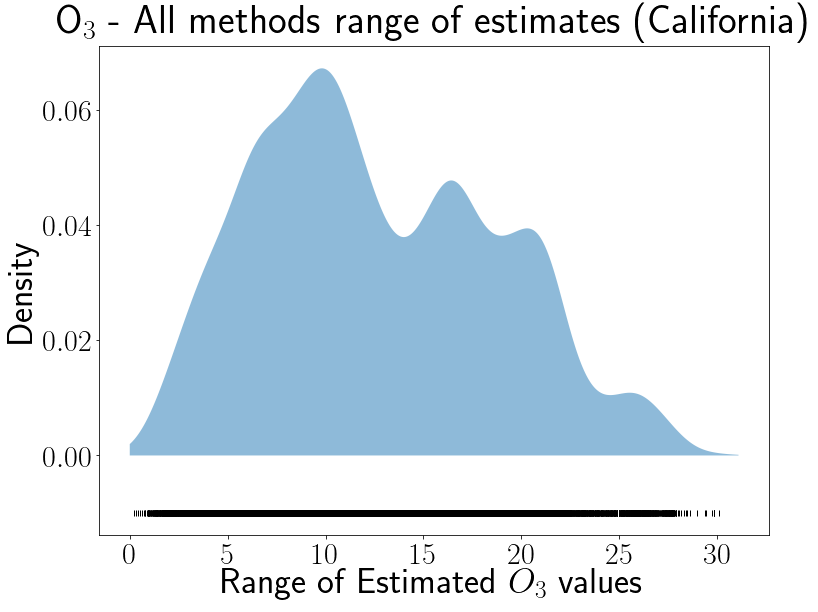

In [46]:
fig = plt.figure(figsize=(12, 9))

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1, kernel='gaussian')
kde.fit(np.array(hist1)[:, None])
logprob = kde.score_samples(x_d[:, None])
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(np.array(hist1), np.full_like(np.array(hist1), -0.01), '|k', markeredgewidth=1)

plt.title("O$_3$ - All methods range of estimates (California)", fontsize=40)
plt.xlabel("Range of Estimated $O_3$ values", fontsize=36)
plt.ylabel("Density",fontsize = 36)
plt.tick_params(axis='both', labelsize=30)